# Missing Imputation

**1. Cause:**
- value does not exist
- Unknown/not identified values 
 
**2. Missing data mechanisms:**
- Missing completely at random (MCAR): the randomly missing and there is no relationship with any other variables
- Missing at random (MAR): Missingness of a variable is related to another variable (A missing if B >= b)
- Missing not at random (MNAR): Missingness of a variable is related to itself (A missing if A >=a)
 
**3. Missing Imputation Techniques use by datatypes:**
- `Numerical` Variables:
    - Mean/median imputation
    - Arbitrary value imputation
    - End of tail imputation
- `Categorical` Variables:
    - Frequent category
    - Adding new "missing" category
- `Both`:
    - Complete Case Analysis
    - Adding new "missing" category
    - Random sample imputation
 
**4. Missing Imputation Techniques comparation:**
| Index| Method | Assumptions | Advantages | Disadvantages | Observations |
| --- | --- | --- | --- | --- | --- |
|1 | Adding a missing indicator | Missing data is predictive | • Easy to implement <br />• Captures importance of “missingness” if there is one | • Increases feature space <br /> • May lead to similar or highly correlated added missing indicators | Other method + adding a missing indicator are widely used in data science competitions and in organisations. |
|2 | `Mean` / `Median` imputation | Value at MCAR | • Easy to implement <br />• Fast way of obtaining complete datasets | • Distortion of original variance <br /> • Distortion of covariance / correlation with other variables within the dataset <br /> • After the imputation, There are many observations that are identified as outliers by boxplot| • `Mean` / `Median` imputation + adding a '`missing`' variable <br /> • `Mean` use for normal distribution and `Median` for otherwise |
|3 | Frequent category imputation | Value at MAR | • Easy to implement <br />• Fast way of obtaining complete datasets | • Distortion the relation of the most frequent label with other variables within the dataset <br /> • May lead to an over-representation of the most frequent label if there is a big number of NA|This is the equivalent of mode imputation and it is used only for categorical variables (mode imputation is not normally used for numerical variables)|
|4 | Random sample imputation | Value at MCAR | • Easy to implement <br />• Fast way of obtaining complete datasets <br />• Preserves the variance of the original variable| • Randomness <br /> • Distortion of covariance / correlation with other variables within the dataset |• Not so widely used in data competitions, but it is used by businesses.<br /> • Need to control the randomness by setting seed random|
|5 | Arbitrary value imputation | Value not at MAR | • Easy to implement <br />• Fast way of obtaining complete datasets <br />• Captures importance of “missingness” if there is one| • Distorts the original distribution of the variable <br /> • If “missingnes”s is not important, it may mask the predictive power of the original variable by distorting its distribution <br /> • Hard to decide which arbitrary value to use<br /> • If the value is outside the distribution it may mask or create outliers|• Typical arbitrary numbers are 9999, -9999 or 'missing'<br /> • Work well with trees, not well in linear model (create bias)|
|5.1 | Endtail distribution imputation | Value not at MAR | • Easy to implement <br />• Fast way of obtaining complete datasets <br />• Captures importance of “missingness” if there is one| • Distorts the original distribution of the variable <br /> • If “missingnes”s is not important, it may mask the predictive power of the original variable <br /> • If the number of NA is big, it will mask true outliers in the distribution<br /> • If the number of NA is small, the replaced NA may be considered outliers and pre-processed in a subsequent step of feature engineering|• NA are flagged as different by assigning a value at the tail of the distribution, where observations are rarely represented in the population.<br /> • Work well with trees, not well in linear model (create bias)|
|5.2 | Missing category imputation | None | • Easy to implement <br />• Fast way of obtaining complete datasets <br />• Captures importance of “missingness” if there is one| • Distorts the original distribution of the variable <br /> • If the number of NA is small, creating an additional category may lead to an additional rare label|• Method of choice, as it treats missing values as a separate category, without making any assumption on their “missingness”. <br /> • Work well with trees, not well in linear model (create bias)|

**5. When to use ?**
- Prefer using `multivariate imputation` than `univariate imputation`, using `common guideline` than `Exceptions guideline`
- Common guideline:
    - If missing-rate < 5%:
        - `Numeric` : use `mean`/`median` or `random sample`
        - `Category`: use `most frequent category` or `random sample`
    - If missing-rate > 5%:
        - `Numeric` : use `mean`/`median` + `missing indicator`
        - `Category`: use `missing category` label
    - Check the missing-value has a value of prediction (có tác dụng dự đoán), if they has, add 'missing indicator', if not, replacing thêm with the most frequent values
- Exceptions to the guideline: If data is not MAR and dont want to attribute the most common occurrence to the missing values. Or dont want to increase the feature space:
    - `Numeric` : use `arbitrary` or `endtail distribution`
    - `Category`: use `arbitrary` or `missing category` label

In [2]:
from plotly.figure_factory import create_distplot
import pandas as pd
from dataprep.eda import plot_missing
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from sklearn.pipeline import Pipeline

class MissingAnalysis:

    def __init__(self, data, features_name = None):
        self.data = data
        # self.data_processed = data
        self.features_name = list(data.columns) if (type(data) == pd.DataFrame) else \
                            (features_name if features_name is not None else 
                            (['feature_' + str(i) for i in range(data.shape[1])]))

    def summary(self, ft_names = None):
        ft_names = self.features_name if ft_names is None else ft_names
        return plot_missing(self.data[ft_names])


    def count_na(self, ft_names = None, view = False):
        ft_names = self.features_name if ft_names is None else ft_names
        df = self.data[ft_names]
        na_count = df.isna().sum().rename('NA_Count')
        na_perc = df.isna().mean().rename('NA_Percent')
        res = pd.concat([na_count, na_perc], axis = 1).sort_values('NA_Count', ascending = False)
        if not view:
            return res
        else:
            res['NA_Percent'] = res['NA_Percent'].map(lambda i: "{:.2f}".format(i*100)+'%')
            return res.style.background_gradient(cmap="Pastel1_r", subset=['NA_Count'])
            # return res


    def compare_hist(self, processed_data, ft_names = None, col = 4):

        ft_names = self.features_name if ft_names is None else ft_names

        if type(ft_names) == list:
            ft_names = [i for i in ft_names if not 
                    (pd.api.types.is_string_dtype(self.data[i]) and self.data[i].nunique() > 15)] # remove the categorical variables with nunique > 15
            row = len(ft_names)//col + 1
            fig = make_subplots(rows = row, cols=col, subplot_titles = ft_names)
            for i, obj in enumerate(ft_names):
                fig.add_trace(go.Histogram(x = self.data[obj] , marker_color = '#F85341' ,name = 'Before', bingroup = i)
                , row=i//col + 1, col=i%col + 1)
                fig.add_trace(go.Histogram(x = processed_data[obj] , marker_color = '#656FF4', name = 'After', bingroup = i)
                , row=i//col + 1, col=i%col + 1)
            fig.update_layout(height=row*350, width=col*350, showlegend=False, barmode='overlay', overwrite=True)
            fig.update_xaxes(categoryorder='category ascending')
            fig.show(renderer="jpeg")

        if type(ft_names) == str:
            fig = create_distplot([self.data[ft_names].dropna(), processed_data[ft_names].dropna()],
            ['Before', 'After'], show_rug=True, bin_size = 30)
            fig.show(renderer="jpeg")

    def compare_boxplot(self, processed_data, ft_names):
        if ft_names not in self.features_name:
            ft_names = self.features_name[ft_names]
        df_before = self.data[[ft_names]]
        df_before['treatment'] = 'Before'
        df_after = processed_data[[ft_names]]
        df_after['treatment'] = 'After'
        df = pd.concat([df_before, df_after], axis = 0)
        fig = px.histogram(df, x=ft_names, color="treatment", marginal="box", barmode = 'overlay',title = ft_names)
        fig.update_xaxes(categoryorder='category ascending')
        fig.show(renderer="jpeg")
 

In [ ]:
import pandas as pd
df = pd.read_csv('Datasets/titanic.csv')

In [ ]:
MissingAnalysis(df).count_na(view = True)

## Complete-case analysis

--> remove all the observation in which there is any missing variables

**1. Advantages**
- simple
- no data manipulation required ( make a fake obs )
- preserves the distribution of variables

**2. Disadvantages**
- remove large of obs and information from the original dataset
- create the bias if the missing information in MAR or in MNAR and not in MAR
- model is not learned to handle missing data in production

**3. When to use ?**
- Data missing MCAR
- No more than 5% of the total dataset contains missing data

In [ ]:
def cca_dropna(data, threshhold = 0.05):
    na_cnt = MissingAnalysis(data).count_na()
    ftnames = na_cnt[na_cnt['NA_Percent'] <= threshhold].index
    return data.dropna(subset = ftnames, how = 'any')

In [ ]:
df_cca = cca_dropna(df, 0.3)

In [ ]:
df_cca.columns

Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest'],
      dtype='object')

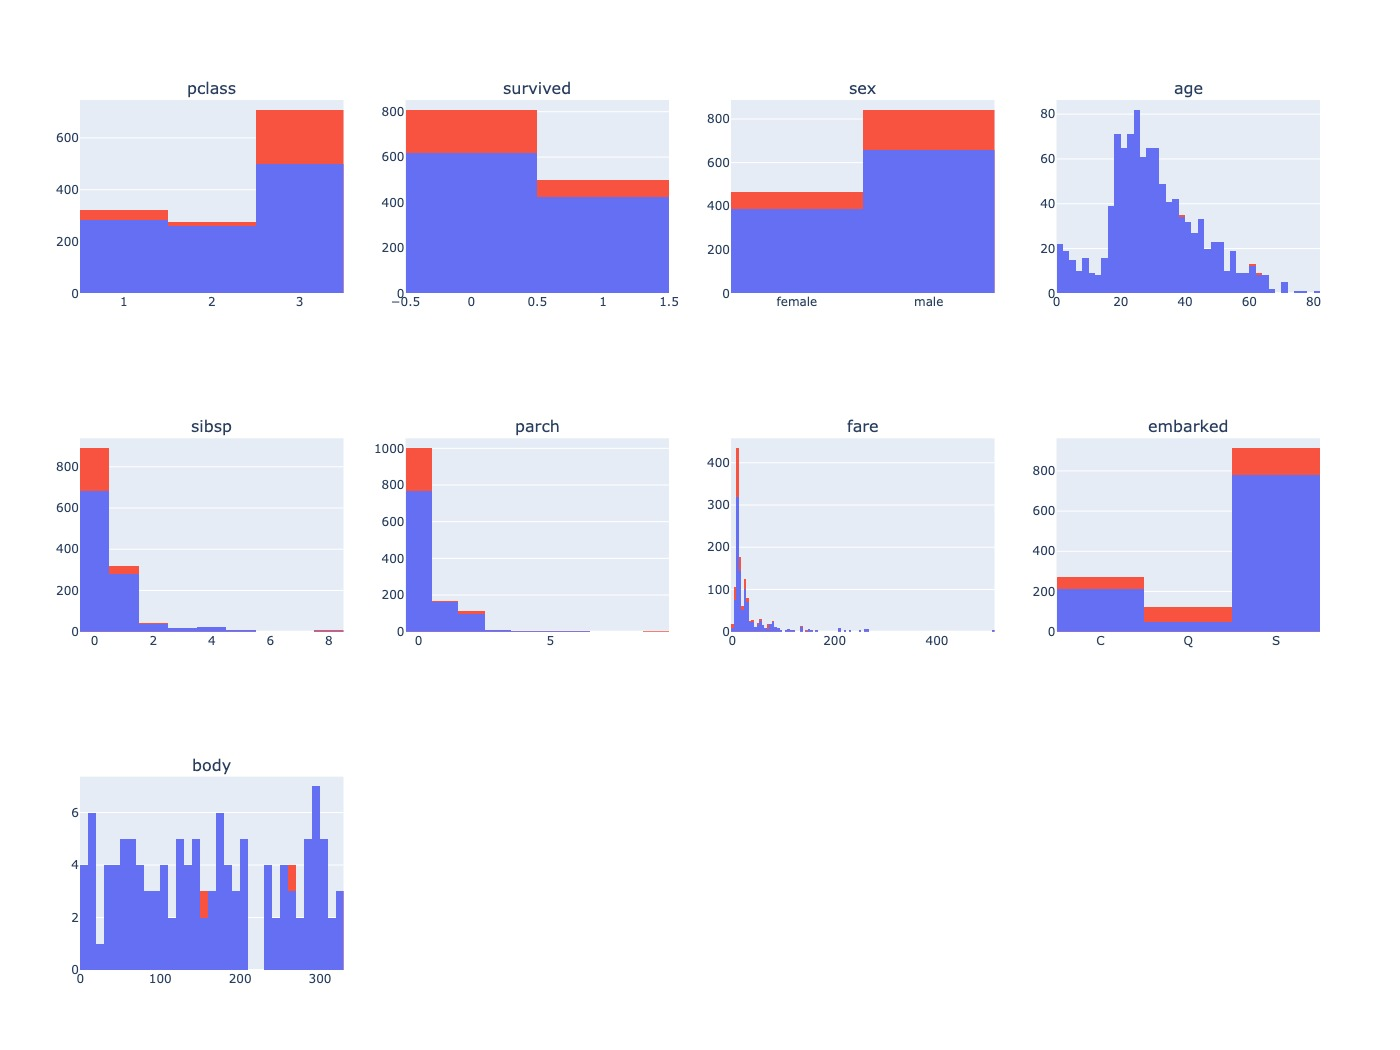

In [ ]:
MissingAnalysis(df).compare_hist(df_cca)

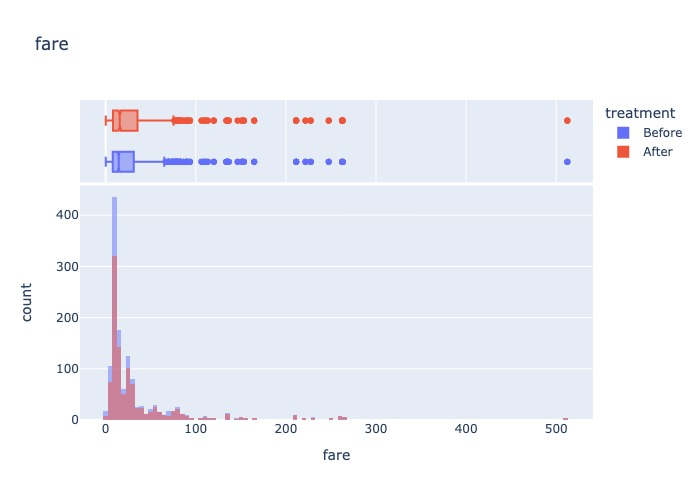

In [ ]:
MissingAnalysis(df).compare_boxplot(df_cca,'fare')

## Mean/Median imputation

- The `mean` and `median` can only be calculated on `numerical variables`. Therefore, these methods are suitable for continuous and discrete numerical variables only.
- Should use together with adding "`Missing Indicator`" new variables to mark observations where the data was missing
- Assumptions: Data is MCAR (Missing completely at random)

**1. Which is suitable for replace ?**
- `Mean` suitable for numeric Normal distribution variables ( for Normally distribution, the mean, median, mode are approximately the same)
- ` Median` suitable for he skewed variables, median represents the majority of the values in the variable better

**2. Advantages**
- Fast way
- Easy deploy to production

**3. Limitations**
- Distortion of original variable distribution (change the variance and the covariance with other variables), the large of distortion depend on the fraction of missing data.
- Lead to observations that are common occurences in the distribution being picked up as outliers
- After the imputation, There are many observations that are identified as `outliers` by `boxplot` when compared to the original data (because of more obs in common by replacing `mean`/`median`) ==> **Should detect outliers before imputation technique**

**4. When should to use ?**
- Data is MCAR and no more than 5% of the variables contains missing data

In [6]:
import pandas as pd
cols_to_use = [
 "OverallQual",
 "TotalBsmtSF",
 "1stFlrSF",
 "GrLivArea",
 "WoodDeckSF",
 "BsmtUnfSF",
 "LotFrontage",
 "MasVnrArea",
 "GarageYrBlt",
 "SalePrice",
]
df = pd.read_csv(f'Datasets/houseprice_train.csv', usecols=cols_to_use)
df.dtypes

LotFrontage    float64
OverallQual      int64
MasVnrArea     float64
BsmtUnfSF        int64
TotalBsmtSF      int64
1stFlrSF         int64
GrLivArea        int64
GarageYrBlt    float64
WoodDeckSF       int64
SalePrice        int64
dtype: object

In [8]:
import random
import numpy as np
for i, var in enumerate(df.columns):
    values = list(set([random.randint(0, len(df)) for p in range(0, 150) if random.randint(0, len(df)) % (i+2) == 0]))
    df.loc[values, var] = np.nan 

### pandas

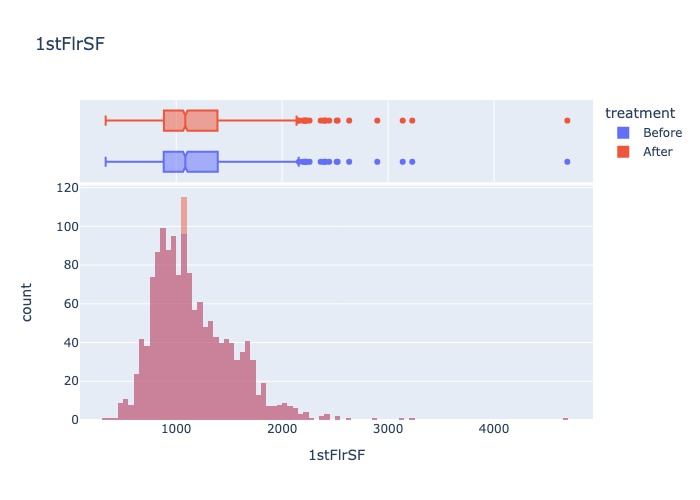

In [ ]:

imputation_dict = df.median().to_dict()
df_median = df.fillna(imputation_dict)

MissingAnalysis(df).compare_boxplot(df_median,5)

### sklearn

In [9]:
# transformers to impute missing data with sklearn:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# to split the datasets
from sklearn.model_selection import train_test_split

# let's separate into training and testing set
X_train, X_test, y_train, y_test = train_test_split(df.drop("SalePrice", axis=1), df["SalePrice"], test_size=0.3)

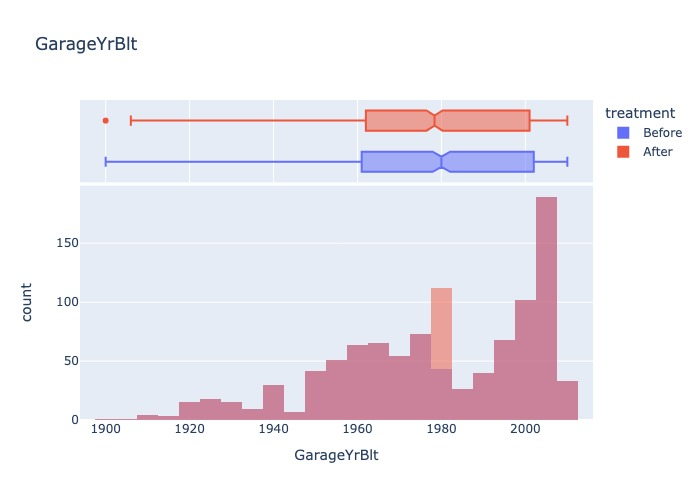

In [ ]:
# set up the imputer, strategy = "median", default output change from "array" to "dataframe"
imputer_simple = SimpleImputer(strategy="median").set_output(transform="pandas")

# setup the imputer with multi-strategy 
cat_imp_fts = []
median_imp_fts = ['LotFrontage']
mean_imp_fts = ["MasVnrArea", "GarageYrBlt"]
imputer_mul = ColumnTransformer(
 transformers = [
 ('cat_imputer', SimpleImputer(strategy='most_frequent'), cat_imp_fts),
 ('median_imputer', SimpleImputer(strategy='median'), median_imp_fts),
 ('mean_imputer', SimpleImputer(strategy='mean'), mean_imp_fts),
 ],
 remainder="passthrough", # remain the columns are not transform, default 'drop' 
 verbose_feature_names_out = False, # not rename the features name with strategy 
 ).set_output(transform="pandas")

# We fit the imputer to the train set
imputer_mul.fit(X_train)

# the learn mean values
imputer_mul.named_transformers_["mean_imputer"].statistics_

# impute missing data
X_train_imputed = imputer_mul.transform(X_train)
X_test_imputed = imputer_mul.transform(X_test)

MissingAnalysis(X_train).compare_boxplot(X_train_imputed,'GarageYrBlt')

### sklearn fillna by mean/median in each group

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class WithinGroupMeanImputer(BaseEstimator, TransformerMixin):
    def __init__(self, group_var, strategy = 'mean', fill_var = None):
        self.group_var = group_var
        self.strategy = strategy
        self.fill_var = fill_var

    def fit(self, X, y=None):
        self.fill_var = self.fill_var if self.fill_var is not None else \
        X.select_dtypes(include=['int', 'float']).columns
        self.statistics_ = X.groupby(self.group_var)[self.fill_var].agg(self.strategy).to_dict('index')
        return self

    def transform(self, X):
        # the copy leaves the original dataframe intact
        X_ = X.reset_index(drop = True).copy()
        for cat in self.statistics_:
            X_.loc[X_[self.group_var] == cat] = X_.loc[X_[self.group_var] == cat].fillna(self.statistics_[cat])
        return X_

im = WithinGroupMeanImputer('OverallQual', fill_var=['MasVnrArea','BsmtUnfSF'], strategy='median').fit(X_train)
X_train_imputed = im.transform(X_train)

### feature-engine

In [ ]:
from sklearn.pipeline import Pipeline

# from feature-engine
from feature_engine.imputation import MeanMedianImputer

pipe = Pipeline(
                 [
                     ( "median_imputer", MeanMedianImputer( imputation_method="median", variables=["LotFrontage", "GarageYrBlt"] ), ),
                     ( "mean_imputer", MeanMedianImputer(imputation_method="mean", variables=["MasVnrArea"]), ),
                 ]
            )

# fit to trainset
pipe.fit(X_train)

# find the learned parametes
pipe.named_steps["median_imputer"].imputer_dict_

# let's transform the data with the pipeline
X_train_t = pipe.transform(X_train)
X_test_t = pipe.transform(X_test)

# let's check null values are gone
X_train_t.isnull().sum()

LotFrontage     0
OverallQual    44
MasVnrArea      0
BsmtUnfSF      14
TotalBsmtSF    16
1stFlrSF       10
GrLivArea      11
GarageYrBlt     0
WoodDeckSF     10
dtype: int64

## Arbitrary value imputation

- Replacing all missing values with specific value (arbitrary value):
    - For numeric: 0, 999, -999 or -1 (if distribution is positive) 
    - For category: New label 'missing'
- Assumptions: Data is not MAR - missing at random, prefer Arbitrary instead of mean/median imputation

**1. Advantages**
- Fast way and easy to handle missing and deploy to production
- Highlights missing observations

**2. Limitations**
- Distortion of the orginal distribution: Distortion of variable distribution , variance and covariance with another.
- Create outliers because the arbitrary often in the end of tail distribution
- Need to be carefull to choose an arbitrary value

**3. When should to use**
- Data is not MAR
- Work well with trees, not well in linear model (create bias)

In [ ]:
# remainder = drop, which means that only the imputed features will be retained, and the rest dropped.

imputer = ColumnTransformer(
 transformers=[
 (
 "imputer_LotFrontAge",
 SimpleImputer(strategy="constant", fill_value=999),
 ["LotFrontage"],
 ),
 (
 "imputer_MasVnrArea",
 SimpleImputer(strategy="constant", fill_value=-10),
 ["MasVnrArea"],
 ),
 (
 "imputer_GarageYrBlt",
 SimpleImputer(strategy="constant", fill_value=1700),
 ["GarageYrBlt"],
 ),
 ],
 remainder="drop",verbose_feature_names_out=False
).set_output(transform="pandas")

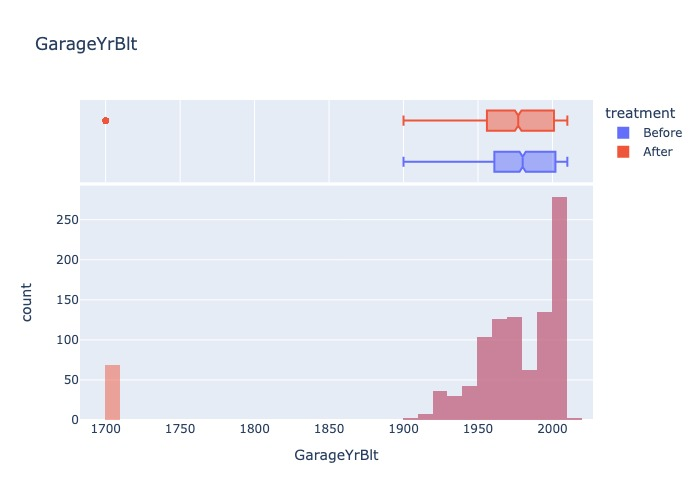

In [ ]:
# now we fit the preprocessor
imputer.fit(X_train)

# the learn mean values
imputer.named_transformers_["imputer_LotFrontAge"].statistics_

# impute missing data
X_train_imputed = imputer.transform(X_train)
X_test_imputed = imputer.transform(X_test)

MissingAnalysis(X_train).compare_boxplot(X_train_imputed,'GarageYrBlt')

### Endtail distribution imputation

Choose the arbitrary value at the end of distribution tail:
- If the variable is normally distributed, we can use the mean plus or minus 3 times the standard deviation: mean +-3std
- If the variable is skewed, we can use the IQR proximity rule (at outlier point or extreme case +-3IQR)

==> Do làm thay đổi distribution nên sẽ ảnh hưởng đến normal assummption của linear model, chỉ work well với tree-base model


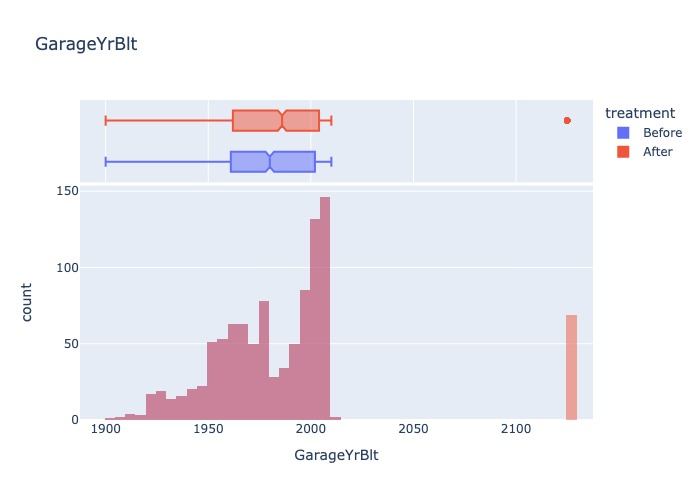

In [ ]:
from feature_engine.imputation import EndTailImputer

# imputer by assumption variable distribution is normal
imputer_rightgausse = EndTailImputer(imputation_method="gaussian", tail="right") # = mean + 3std

# imputer by skewed distribution for specific variables
imputer_leftIQR = EndTailImputer(imputation_method="iqr", tail="left", variables=["LotFrontage", "MasVnrArea"])

# pipeline for endtail imputer
pipe = Pipeline([
 ("imputer_skewed",EndTailImputer(imputation_method="iqr",tail="right",variables=["GarageYrBlt", "MasVnrArea"],),),
 ("imputer_gaussian",EndTailImputer(imputation_method="gaussian", tail="right", variables=["LotFrontage"]),),
 ])

# now we fit the preprocessor
pipe.fit(X_train)

# the learn mean values
pipe.named_steps["imputer_gaussian"].imputer_dict_

# impute missing data
X_train_imputed = pipe.transform(X_train)
X_test_imputed = pipe.transform(X_test)

MissingAnalysis(X_train).compare_boxplot(X_train_imputed,'GarageYrBlt')

### Missing category imputation
- Assign the missing value with '`missing`' label, suitable for categorical variables and high missing-rate

**1. Advantages**
- Fast way of obtaining complete datasets
- Highlights missing data in raw-data
- No assumptions made on the data

**2. Limitations**
- Only suitable for highly missing-rate in categorical variables, with low-rate the creating new label for variables may be make noise


In [ ]:
imputer_simple = SimpleImputer(strategy="most_frequent").set_output(transform="pandas")

## Frequent category imputation | Mode imputation

- Replace all occurrences of missing values within variable by the mode, thich is the most frequent value or most frequent category. In practice, we use only use the mothod on categorical variables.
- Assumption: Data is MCAR

**1. Advantages**
- Fastway to complete datasets

**2. Limitations**
- If missing-rate is high, distortion the relation of the most frequent category with other variables
- Over-representation of the most frequent category

**3. When should to use ?**
- Data is the MCAR and missing-rate < 5%

In [ ]:
# use make_column_transformer

from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector

imputer = make_column_transformer(
 (SimpleImputer(strategy="mean"), make_column_selector(dtype_include=np.number)),
 (SimpleImputer(strategy="most_frequent"), make_column_selector(dtype_include=object)),
)

In [ ]:
imputer = SimpleImputer(strategy="constant",fill_value="Missing")

## Random sample imputation
- Take random observations from the pool of availabel data and using them to replace the NA so the distribution of variables is preserved by sampling observations at random, use it for both numeric and categorical variables
- Should be combine random sample imputation with adding missing indicators
- Assumptions: Data is MCAR

**1. Advantages**
- Preserves the variable distribution

**2. Limitations**
- **Randomness**: The results of 2 observations, that have the same non-missing features, may be different of estimation because the random fill missing value. Or the estimation of observation is not stable in multi of executing the model. 
- The relationship of imputed variables with other variables may be affected, Covariance & correlations with other variables in dataset may be distorted with original dataset
- Computationally more expensive than other method
- Memory heavy, because need to keep a copy of original training set

**3. When should to use ?**
- Data is MCAR
- Missing-rate <5%
- Suited for linear models (dont want to distort the distribution)
- Setting seeds to control the randomness

-> **Not as widely used in DS as the mean/median imputation, presumably because of randomness and code implementation is not so straighforward**

In [ ]:
# from feature-engine
from feature_engine.imputation import RandomSampleImputer

imputer = RandomSampleImputer(random_state=29)

## Missing indicator
- Flagging the NA value with a missing indicator (new binaty feature) that indicates whether the data was missing (1) or not (0), use for bot `category` and `numeric`
- If data was missing is MAR, fillna imputation will captured and if it's wasn't, this would be capture by missing indicator
- Missing indicator is never used along, it is always used together with another imputation technique. Commonly used together:
    - `Mean/median imputation` + `missing indicator` (Numerical variables)
    - `Frequent category imputation` + `missing indicator` (categorical variables)
    - `Random sample imputation` + `missing indicator` (numerical and categorical)
- Assumptions:
    - Data is not MAR
    - Missing data is predictive
 
**1. Advantages**
- Capture the importance of missing data if there is one

**2. Limitations**
- Expands the feature space
--> some cross variables tends to be missing value together, add 1 missing indicator for group of features to get smaller adding features to space.
- Many missing indicators may very highly correlated

**3. When should to use ?**
- Should to use if handle the performance when expand the features space


In [ ]:
from sklearn.impute import SimpleImputer, MissingIndicator

# add missing indicator
indicator = MissingIndicator(error_on_new=True, features="missing-only",)
indicator.fit(X_train)

# We can see the features that contained NA. 
indicator.features_ # The result shows the index of the columns.
X_train.columns[indicator.features_] # The result shows the list of columns contained NA.

# transform the dataset
tmp = indicator.transform(X_train)

# variable names for the indicators come out of the box
indicator.get_feature_names_out()


array(['missingindicator_LotFrontage', 'missingindicator_OverallQual',
       'missingindicator_MasVnrArea', 'missingindicator_BsmtUnfSF',
       'missingindicator_TotalBsmtSF', 'missingindicator_1stFlrSF',
       'missingindicator_GrLivArea', 'missingindicator_GarageYrBlt',
       'missingindicator_WoodDeckSF'], dtype=object)

In [ ]:
# adding missing indicator via imputer by parameter 'add_indicator'
imputer = SimpleImputer(strategy="most_frequent", add_indicator=True,).set_output(transform="pandas")


In [ ]:
# pipeline via feature-engine
from feature_engine.imputation import AddMissingIndicator

pipe = Pipeline(
 [
 # missing indicator
 ("missing_ind", AddMissingIndicator(variables=["BsmtQual", "FireplaceQu", "LotFrontage"])),
 # mode imputation
 ("imputer_mode", SimpleImputer(strategy="most_frequent"), ["FireplaceQu", "BsmtQual"]),
 # median imputation
 ("imputer_mean", SimpleImputer(strategy="mean"), ["LotFrontage", "MasVnrArea", "GarageYrBlt"]),
 ]
)

## Grid-search for selection of best imputation technique

In [ ]:
# import classes for imputation
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# import classes for modelling
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, GridSearchCV

In [ ]:
# read data
df = pd.read_csv(f'Datasets/houseprice_train.csv')

# let's separate into training and testing set
X_train, X_test, y_train, y_test = train_test_split(df.drop("SalePrice", axis=1), df["SalePrice"], test_size=0.3)

# feature's name
features_categorical = [c for c in X_train.columns if X_train[c].dtypes == "O"]
features_numerical = [c for c in X_train.columns if X_train[c].dtypes != "O"]

In [ ]:
# preprocessing
numeric_transformer = Pipeline(
 steps=[
 ("imputer", SimpleImputer(strategy="median")), 
 ("scaler", StandardScaler())
 ]
)

categorical_transformer = Pipeline(
 steps=[
 ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
 ("onehot", OneHotEncoder(handle_unknown="ignore")),
 ]
)

preprocessor = ColumnTransformer(
 transformers=[
 ("numerical", numeric_transformer, features_numerical),
 ("categorical", categorical_transformer, features_categorical),
 ]
)

In [ ]:
# model pipeline
pipe = Pipeline(
 steps=[("preprocessor", preprocessor), ("regressor", Lasso(max_iter=2000))]
)

In [ ]:
# the grid with all the parameters that we would like to test
param_grid = {
 "preprocessor__numerical__imputer__strategy": ["mean", "median"],
 "preprocessor__categorical__imputer__strategy": ["most_frequent", "constant"],
 "regressor__alpha": [10, 100, 200],
}

grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, scoring="r2")

In [ ]:
# fit to model
grid_search.fit(X_train, y_train)

# best performance
print('best performance', grid_search.score(X_train, y_train))

# best estimator parameter
best_estimator = grid_search.best_estimator_

best performance 0.9247069170278462


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Id', 'MSSubClass',
                                                   'LotFrontage', 'LotArea',
                                                   'OverallQual', 'OverallCond',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'BsmtFinSF2', 'BsmtUnfSF',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   '2ndFlrSF', 'LowQualFinSF'...
                                                   'LotConfig', 'LandSlope',
                                                   'Neighborhood', 'Condition1',
                                                   'Condition2', 'BldgType',
                                                   'HouseStyle', 'RoofStyle',
                                                   'RoofMatl', 'Exterior1st',
                                                   'Exterior2nd', 'MasVnrType',
                                                   'ExterQual', 'ExterCond',
                                                   'Foundation', 'BsmtQual',
                                                   'BsmtCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', ...])])),
                ('regressor', Lasso(alpha=100, max_iter=2000))])

In [ ]:
# and find the best fit parameters like this
grid_search.best_params_

{'preprocessor__categorical__imputer__strategy': 'most_frequent',
 'preprocessor__numerical__imputer__strategy': 'mean',
 'regressor__alpha': 100}

## KNN imputation
- The missing values are estimated as the average value from the closest K neighbours. The logic is that the missing value would be similar to the value shown in those similar observations
- The weight to calculate the average value follow the `Uniform` or `Eunclidean distance` method

**1. Challenge**
- Find the optimal K parameter, that are apply to all variables that use KNN imputation
    - Spend time to tunning K
    - Same K will be used to impute all variables
- If we want to predict more accurately as possible the values of the missing data, then, we would use the KNN imputer, we would build individual KNN algorithms to predict 1 variable from the remaining ones
- KNN imputation can be sensitive to outliers, as it relies on the values of the nearest neighbors
- KNN imputation can be biased towards the majority class in the dataset, as it uses the values of the majority class to fill in the missing values.

**2. How to use ?**
- Lower missing-rate (<20%), the KNN imputation more precise.
- The usual K between 10 and 20, although this method is relative insensitive to the value of K

In [ ]:
from sklearn.impute import KNNImputer
from feature_engine.wrappers import SklearnTransformerWrapper

# simple KNN Imputer
imputer = KNNImputer(
 n_neighbors=5, # the number of neighbours K
 weights='distance', # the weighting factor
 metric='nan_euclidean', # the metric to find the neighbours
 add_indicator=False, # whether to add a missing indicator
)

# use KNN for a slice of data
imputer = SklearnTransformerWrapper(
 transformer = KNNImputer(weights='distance'),
 variables = ['MSSubClass', 'LotFrontage', 'LotArea', 
 'OverallQual', 'OverallCond', 'YearBuilt'], # specific variables use KNN Imputation
)

In [ ]:
# gridSearch for KNN
pipe = Pipeline(steps=[
 ('imputer', KNNImputer(
 n_neighbors=5,
 weights='distance',
 add_indicator=False)),
 
 ('scaler', StandardScaler()),
 ('regressor', Lasso(max_iter=2000)),
])

param_grid = {
 'imputer__n_neighbors': [3,5,10],
 'imputer__weights': ['uniform', 'distance'],
 'imputer__add_indicator': [True, False],
 'regressor__alpha': [10, 100, 200],
}

grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, scoring='r2')

## MICE
**Multivariate Imputation of Chained Equations**
- For each variable, use the series (multi-time) of models to predict the missing value by other variables in the data
- Each incomplete variables is imputed by a separate model
- **For this particular pattern of missing values we see that `BayesianRidge` and `RandomForestRegressor` give the best results. `HistGradientBoostingRegressor` are often recommended over building pipelines with complex and costly missing values imputation strategies.**


**1. Framework**
- B1: Impute all the missing variables with a very simple imputation method (like mean,..) in the original dataset with missing value across multi variables
- B2: Choose 1 variable that have missing value in raw data, and reverted which obs missing back to NA
- B3: Predict the missing value by other variables with specific algorithms
- B4: Back to B2 with another missing variable, do this repeatation for all variables, 1 round of imputation is completed
- B5: The procedure repeats itself n times, uaually 10 imputation cycles are enough to find `stable parameters` for the models:
     - In the first round, the predictions might be biased because the model base on the truely missing values, they are imputed by simple method
     - Continue to regress to obtain better estimates for NA and returning more accurate predictions

**2. Assumptions**
- Data is MAR
- The NA in variables can be modelled by the other variables, dose not depend on external sources.

**3. Challenge to use MICE**
- Variables relationship:
     - Variables may have linear or non-linear relationship with others
     - Find the best model to predict the missing data (`Linear Regression`, `Bayes`, `Tree-base`,...) and find the best optimal model parameters
- Variable nature: which model should use to impute different datatype of variables ?
     - Binary variable --> classification algorithms
     - Continuous variable --> regression algorithms
     - Discrete variables --> Poison
- Build manually and tunning for each variables imputation, In `sk-learn`:
     - Same model will be used to predict NA in all variables
     - Can't use `classification` for `binary variables` and `regression` for `continuous variables` together
- Variables which is imputed by others, would have correlated with others

In [ ]:
# load data with numerical variables
variables = ['A2','A3','A8', 'A11', 'A14', 'A15', 'A16']
data = pd.read_csv(f'Datasets/creditApprovalUCI.csv', usecols=variables)

X_train, X_test, y_train, y_test = train_test_split(
 data.drop('A16', axis=1), data['A16'], test_size=0.3, random_state=0)

In [ ]:
# NOTE: This estimator is still experimental for now: the predictions and 
# the API might change without any deprecation cycle. 
# To use it, you need to explicitly import enable_iterative_imputer:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge

from sklearn.experimental import enable_iterative_imputer # explicitly require this experimental feature
from sklearn.impute import IterativeImputer

# let's create a MICE imputer using Bayes as estimator
imputer = IterativeImputer(
     estimator=BayesianRidge(), # the estimator to predict the NA
     initial_strategy='mean', # how will NA be imputed in step 1
     max_iter=10, # number of cycles
     imputation_order='ascending', # the order in which to impute the variables
     n_nearest_features=None, # whether to limit the number of predictors
     skip_complete=True, # whether to ignore variables without NA
     random_state=0,
        )

# perform MICE
imputer.fit(X_train)

# transform the data - replace the missing values
train_t = imputer.transform(X_train)
test_t = imputer.transform(X_test)

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

# other estimator
imputer_hgbr = IterativeImputer(
 estimator=HistGradientBoostingRegressor(),
 max_iter=10,
 random_state=0)

imputer_knn = IterativeImputer(
 estimator=KNeighborsRegressor(n_neighbors=5),
 max_iter=10,
 random_state=0)

imputer_nonLin = IterativeImputer(
 estimator=DecisionTreeRegressor(max_features='sqrt', random_state=0),
 max_iter=500,
 random_state=0)

imputer_missForest = IterativeImputer(
 estimator=ExtraTreesRegressor(n_estimators=10, random_state=0),
 max_iter=100,
 random_state=0)

### MissForest
- That MICE implementation where `Random Forest` are used to regress the missing variables to the other variables in the data
 - Work well with mixed datatypes
 - Robust and accurate
 - Handles non-linear relationoships and variable iterations

In [ ]:
from missingpy import MissForest
imputer = MissForest()